In [54]:
import harvest_arxiv
import pandas as pd
import numpy as np
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import FeatureUnion
import keras

Using TensorFlow backend.


In [55]:
print("sklearn version:",sklearn.__version__)
print("nltk version:", nltk.__version__)
print("tensorflow version:", tf.__version__)
print("keras version:", keras.__version__)

sklearn version: 0.20.2
nltk version: 3.2.4
tensorflow version: 1.12.0
keras version: 2.2.4


In [2]:
##to harvest math arxiv data and save the file as a csv file
if "complete_math_arxiv.csv" not in os.listdir():
    df = harvest_arxiv.harvest(arxiv="math", start="1989-01-01", end="2018-12-31")
    df.to_csv("complete_math_arxiv.csv",index=False,encoding="utf-8")
    del df

In [3]:
##assume we have it 
df = pd.read_csv("complete_math_arxiv.csv")

/Users/ben/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## let's take a look of the dataframe

In [5]:
df.head()

,abstract,authors,categories,created,id,title,updated
0,We construct a generic extension in which the ...,"['Thomas Jech', 'Saharon Shelah']",['math.LO'],1989-04-14,math/9201239,A note on canonical functions,1989-04-14
1,It is shown that if $C$ is an $n$-dimensional ...,['Keith Ball'],"['math.MG', 'math.FA']",1989-10-26,math/9201205,Volume ratios and a reverse isoperimetric ineq...,1989-10-26
2,It is proved that if $C$ is a convex body in $...,['Keith Ball'],"['math.MG', 'math.FA']",1989-10-26,math/9201204,Shadows of convex bodies,1989-10-26
3,"It is proved that if $u_1,\ldots, u_n$ are vec...","['Keith Ball', 'Alain Pajor']","['math.MG', 'math.FA']",1989-10-26,math/9201203,Convex bodies with few faces,1989-10-26
4,"This note deals with the following problem, th...","['Gideon Schechtman', 'Joel Zinn']","['math.FA', 'math.MG']",1989-11-09,math/9201206,On the volume of the intersection of two $L_p^...,1989-11-09


####  the authors and categories are string, we need to reformat them

In [82]:
def list_of_authors(text):
    names=[]
    name_list=text.split(',')
    for name in name_list:
        name=name.strip()
        if name[0]=='[':
            name=name[1:]
        if name[-1]==']':
            name=name[:-1]
        name=name[1:-1]
        names+=[name]
    return names    


def list_of_categories(text):
    pat=re.compile(r'math.[A-Z][A-Z]')
    return pat.findall(text)

##now we can make them into a list
df['categories']=df['categories'].apply(lambda x: list_of_categories(x))
df['authors']=df['authors'].apply(lambda x: list_of_authors(x))

### In order to do NLP on the abstract of the math paper, we should also remove all math symbol (i.e. latex) and other symbols

In [116]:
def cancelmath_and_quote(test_str):
    regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

    subst = ""

    result = re.sub(regex, subst, test_str, 0, re.MULTILINE)
    
    regex = r"(\[+)(?:(?!\1)[\s\S])*\1"
    
    subst = ""

    result = re.sub(regex, subst, result, 0, re.MULTILINE)
    
    ###and remove all symbols
    
    regex = r'[\\\$\^\+\-\&\%\!\`\~]'

    subst = ""

    result = re.sub(regex, subst, result, 0, re.MULTILINE) 
    
 

    return result

df['abstract']=df['abstract'].apply(lambda x : cancelmath_and_quote(x))
df['title']=df['title'].apply(lambda x : cancelmath_and_quote(x))

### we have deleted all symbols in title and abstract , now take look of the dataframe again

In [133]:
df.sample(10,random_state=0)

,abstract,authors,categories,created,id,title,updated
101602,"In this paper, we prove the wellposedness for ...",[Zhichun Zhai],[math.AP],2009-06-28,0906.5140,Wellposedness for fractional NavierStokes equa...,2009-06-28
196297,We prove that the subgroup permutability degre...,[Stefanos Aivazidis],[math.GR],2013-06-17,1306.4,On the subgroup permutability degree of the si...,2013-08-11
106315,This paper establishes inner bounds on the sec...,"[Yeow-Khiang Chia, Abbas El Gamal]",[math.IT],2009-10-08,0910.1407,3Receiver Broadcast Channels with Common and C...,2011-06-18
148918,The notion of IgusaTodorov classes is introduc...,[Jiaqun Wei],"[math.RA, math.KT, math.RT]",2011-09-28,1109.61,Finitistic Dimension Conjecture and Conditions...,2011-09-28
289268,In this paper a unifying energybased approach ...,"[Tjerk Stegink, Claudio De Persis, Arjan van d...",[math.OC],2016-04-18,1604.05,A unifying energybased approach to stability o...,2016-07-27
371853,"We establish the sharp growth order, up to eps...","[Francesco Di Plinio, Ioannis Parissis]",[math.CA],2018-07-22,1807.08,Maximal directional operators along algebraic ...,2018-07-22
203950,In this paper we study the moduli space of 4di...,"[Alice Fialowski, Michael Penkava]",[math.RA],2013-09-24,1309.61,The moduli space of 4dimensional nonnilpotent ...,2013-09-24
256366,The propagation of waves through microstructur...,"[Mehul Makwana, Tryfon Antonakakis, Ben Maling...",[math.MP],2015-05-12,1505.03,Wave mechanics in media pinned at Bravais latt...,2015-05-12
163933,We use a theorem of Chow (1949) on linepreserv...,"[Sudhir R. Ghorpade, Krishna V. Kaipa]","[math.AG, math.IT]",2012-04-24,1204.55,Automorphism groups of Grassmann codes,2013-05-20
2623,"We consider the (A_n,A_1) Ysystem arising in t...","[Edward Frenkel, Andras Szenes]",[math.AG],1995-07-02,hep-th/9506215,Thermodynamic Bethe Ansatz and Dilogarithm Ide...,1995-08-20


In [135]:
###Let's drop all papers without math categories
df=df[df.categories.apply(lambda x: len(x)>0)]

### how many different math categories are there?

In [136]:
all_cat={}
for i in df.index:
    paper_cats=df.loc[i,"categories"]
    for cat in paper_cats:
        if cat in all_cat:
            all_cat[cat]+=1
        else:
            all_cat[cat]=1
            
list_of_all_cat=sorted(list(all_cat.items()),key=lambda x: x[1], reverse=True)            

### Let's create a barplot and see its distribution

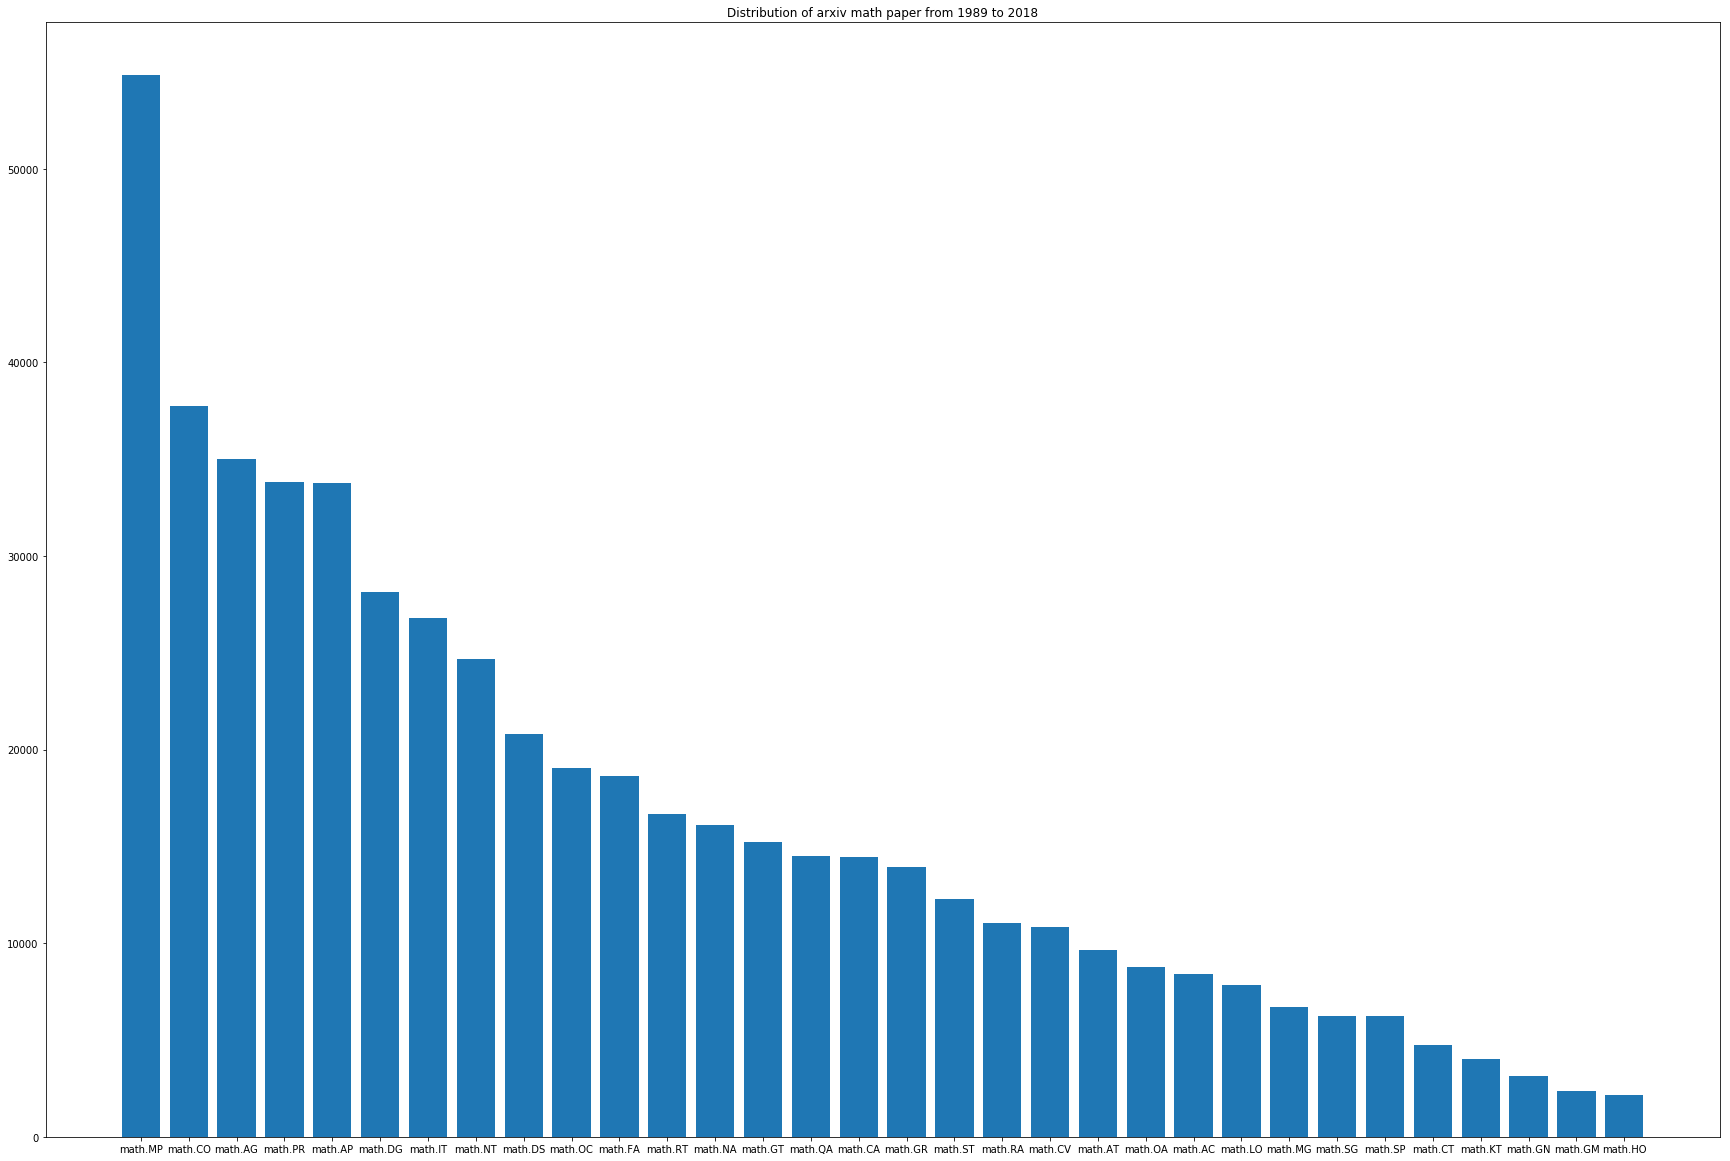

In [161]:
'''
temp_X,temp_y=list(zip(*sorted(F1s,key=lambda x:x[1])))
fig, ax = plt.subplots()
fig.set_size_inches(40, 10.5)
plt.bar(temp_X, temp_y)
# plt.figure(figsize=(200,200))
#plt.xticks(x, ('Bill', 'Fred', 'Mary', 'Sue'))
plt.show()
'''

X_cat,Y_cat=list(zip(*list_of_all_cat))
fig, ax = plt.subplots()
fig.set_size_inches(30, 20.5)
plt.bar(X_cat, Y_cat)
# plt.figure(figsize=(200,200))
#plt.xticks(x, ('Bill', 'Fred', 'Mary', 'Sue'))
plt.title("Distribution of arxiv math paper from 1989 to 2018")
plt.show()

### So the winner is math.MP (Mathematical Physics) , 1st runner up is Combinatorics and 2nd runner up is Algebraic geometry. 